## NYC_taxi Dataset 활용한 회귀

- Dataset : NYC_taxi.csv
- 거리에 따른 택시요금 예측
- 조건) 뉴욕시 내에서 승차/하차의 경우만 

### [0] 모듈 로딩

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

### [1] 데이터 로딩

In [2]:
# 데이터 로딩
FILE='./NYC_taxi_data/train.csv'
df=pd.read_csv(FILE, nrows=500000, parse_dates=['pickup_datetime'])

In [3]:
# 데이터 확인
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype              
---  ------             --------------   -----              
 0   key                500000 non-null  object             
 1   fare_amount        500000 non-null  float64            
 2   pickup_datetime    500000 non-null  datetime64[ns, UTC]
 3   pickup_longitude   500000 non-null  float64            
 4   pickup_latitude    500000 non-null  float64            
 5   dropoff_longitude  499995 non-null  float64            
 6   dropoff_latitude   499995 non-null  float64            
 7   passenger_count    500000 non-null  int64              
dtypes: datetime64[ns, UTC](1), float64(5), int64(1), object(1)
memory usage: 30.5+ MB


In [4]:
df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16+00:00,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42+00:00,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00+00:00,-73.968095,40.768008,-73.956655,40.783762,1


In [5]:
df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,500000.000000,500000.000000,500000.000000,499995.000000,499995.000000,500000.000000
mean,11.358361,-72.519958,39.920276,-72.522435,39.916526,1.683428
std,9.916617,11.856831,8.073475,11.797362,7.391002,1.307395
min,-44.900000,-2986.242495,-3116.285383,-3383.296608,-2559.748913,0.000000
25%,6.000000,-73.992047,40.734917,-73.991382,40.734057,1.000000
50%,8.500000,-73.981785,40.752670,-73.980126,40.753152,1.000000
75%,12.500000,-73.967117,40.767076,-73.963572,40.768135,2.000000
max,500.000000,2140.601160,1703.092772,40.851027,404.616667,6.000000


In [6]:
# 이상치 및 결측치 체크
df.isnull().sum()

key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    5
dropoff_latitude     5
passenger_count      0
dtype: int64

In [7]:
# (0) key값은 DB의 PrimaryKey로 쓰면서 들어간 것이고, 
#     pickup_datetime 컬럼과 같은 내용이므로 불필요한 컬럼으로 삭제할 것
#     (+ pickup_datetime => 문자열로 되어있었으나, 읽어올 때 바로 바꿔줌)
# (1) null값 5개씩 있는 컬럼 있음
# (2) shape확인 (500000행 x 8열)
# (3) 0-7(피처), 거리에 따른 요금(타겟)을 위해 'distance(거리) 피처' 추가
# (4) 요금 min값에 -44.9로 음수값이 있음을 확인
# (5) 승하차 경도와 위도는 있는데, 승객 카운팅이 안되는 행이 있는가 봄
# (6) 경도와 위도가 0인 값은 없구만 => '뉴욕시 내(內)' 조건 충족시키기

### [2] 데이터 준비

In [8]:
# 원본 복사
df2 = df.copy(deep=True)

# key 컬럼 제거
df2.drop(labels='key', axis=1, inplace=True)

# 결측치 제거 (50만개 중 5개라서 안해줘도 될 것 같긴함)
df2 = df2.dropna()

# distance 피처 추가
df2['distance'] = ((df2.pickup_latitude - df2.dropoff_latitude)**2 + (df2.pickup_longitude - df2.dropoff_longitude)**2)**0.5

In [9]:
# 요금 데이터 확인하고 전처리
len(df2[df2.fare_amount>100])  # 214개로 0.05%도 안되므로 100이하만 남기면 될 듯
len(df2[df2.fare_amount<0])    # 21개로 0보다 작은 음수 행도 지우면 될 듯

df2 = df2[(df2.fare_amount >=0) & (df2.fare_amount <= 100)]

# 승객 카운팅 안된 것 전처리
len(df2[df2.passenger_count==0])  # 1791개로 0.3%정도. 전제 데이터가 50만개가 넘으니 삭제할거임
df2.drop(df2[df2.passenger_count==0].index.values, inplace=True)

In [10]:
df2.columns

Index(['fare_amount', 'pickup_datetime', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'distance'],
      dtype='object')

In [11]:
# '뉴욕시 내(內)' 조건 충족시키기
# (대략) 경도 -74.05  ~  -73.75 사이
#        위도 40.63  ~   40.85 사이

df2 = df2[(df2.pickup_longitude > -74.05) & (df2.pickup_longitude < -73.75)]
df2 = df2[(df2.dropoff_longitude > -74.05) & (df2.dropoff_longitude < -73.75)]

df2 = df2[(df2.pickup_latitude > 40.63) & (df2.pickup_latitude < 40.85)]
df2 = df2[(df2.dropoff_latitude > 40.63) & (df2.dropoff_latitude < 40.85)]

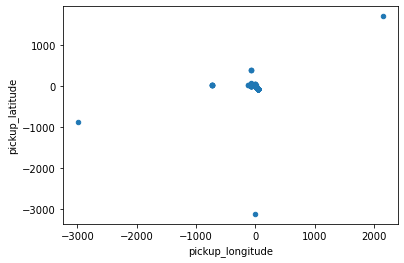

In [12]:
# (일부 전처리 전 data포함) df1의 산점도 => 이상치 보임
df.plot.scatter('pickup_longitude', 'pickup_latitude')
plt.show()

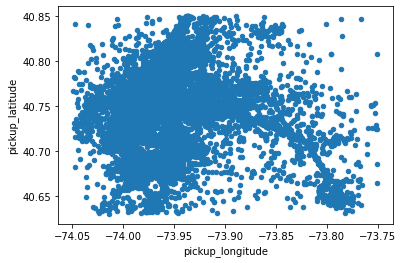

In [13]:
# 전처리한 후의 df2의 산점도 => 뉴욕시 내에만 데이터들이 들어옴
df2.plot.scatter('pickup_longitude', 'pickup_latitude')
plt.show()

In [14]:
# # 피처와 타겟 잡아주기
# X = np.array(df2.distance).reshape(-1,1)
# y = np.array(df2.fare_amount).reshape(-1,1)

# train_input, test_input, train_target, test_target = train_test_split(X,
#                                                                       y,
#                                                                       random_state=42)

# 시리즈로 해서 -> 다항회귀 때, 항 제곱해서 넣을 때 오류 발생 -> 미리 처리 해주고 진행할 것

In [15]:
# 피처와 타겟 잡아주기
# 주의!! 시리즈는 못 넣음
train_input, test_input, train_target, test_target = train_test_split(np.array(df2.distance),
                                                                      np.array(df2.fare_amount),
                                                                      random_state=42)

train_input = train_input.reshape(-1,1)
test_input = test_input.reshape(-1,1)

### [3] 모델 생성

In [16]:
# 선형/다항/다중 회귀는 모두 선형회귀 모델 생성
model = LinearRegression()

### [4] 모델 훈련

In [17]:
model.fit(train_input, train_target)

# 모델 파라미터
# print('분류 종류: ', model.classes_) <- 선형회귀
print('기  울  기: ', model.coef_)
print('절      편: ', model.intercept_)
# print('피처 갯수: ', model.n_features_in_) <- 굳이x

기  울  기:  [213.93987537]
절      편:  3.991206947225707


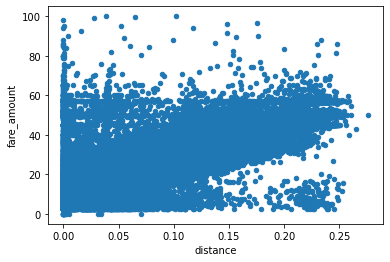

In [18]:
# distance와 fare_amount의 관계 확인
df2.plot.scatter('distance','fare_amount')
plt.show()

### [5] 모델 평가

In [19]:
print('훈련용 : ', model.score(train_input, train_target))
print('검증용 : ', model.score(test_input, test_target))
print('\n=> 훈련점수 < 테스트점수 & 둘다 낮은 점수\n=> 과소적합 문제 => 제곱항을 넣어서 좀 더 복잡하게 다항식으로 만들어 보자(다항회귀)')

훈련용 :  0.7803196614920731
검증용 :  0.782817436943904

=> 훈련점수 < 테스트점수 & 둘다 낮은 점수
=> 과소적합 문제 => 제곱항을 넣어서 좀 더 복잡하게 다항식으로 만들어 보자(다항회귀)


### [6] 모델 예측

In [20]:
print('예측값 : ', model.predict([[0.056]]))

예측값 :  [15.97183997]


### [ 다항회귀 ]

In [21]:
# 데이터 준비
train_input_p = np.column_stack((train_input ** 2, train_input))
test_input_p = np.column_stack((test_input ** 2, test_input))

In [22]:
# 모델 생성
model2 = LinearRegression()

In [23]:
# 모델 훈련
model2.fit(train_input_p, train_target)

LinearRegression()

In [24]:
# 모델 파라미터
print('기  울  기: ', model2.coef_)
print('절      편: ', model2.intercept_)

기  울  기:  [-59.34645435 224.59276454]
절      편:  3.782976797797004


In [25]:
# 모델 평가
print('훈련용 : ', model2.score(train_input_p, train_target))
print('검증용 : ', model2.score(test_input_p, test_target))
print('\n=> 별차이 없노')

훈련용 :  0.7806553284149444
검증용 :  0.7830557820346296

=> 별차이 없노


In [26]:
# 모델 예측
exp = model2.predict([[0.15 ** 2, 0.15]])
exp

array([36.13659626])

In [27]:
print('예측값 :', exp[0])

예측값 : 36.13659625629419


1) 회귀선 그리는 것 (2차원으로 해서 넣는?)